# EELS SrFeO Project 
## PCA and t-SNE Classification

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on PCA

* https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491
* http://www.swst.org/wp/meetings/AM07/labbe.pdf
* https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
* https://faithfull.me/using-pca-when-there-are-less-samples-than-dimensions/
* https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca
* https://www.nature.com/articles/nmeth.4346.pdf?proof=true


### Import Package

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False
import numpy as np
import scipy
import seaborn as sns; sns.set()

### Loading Data

In [22]:
# loading initial data
data_initial = hs.load('processed_data/EELS_initial*.hdf5', signal_type="EELS", stack=False)
data_anneal = hs.load('processed_data/EELS_final*.hdf5', signal_type="EELS", stack=False)

## Principle Component Analysis
- Perform PCA on the 2 regions 
- reconstructing eigen components into 30x300 image & deconstruct again using PCA 

Essentially, I'm trying to use varience to explain my data. 

### Normalizing data

In [23]:
''' 
Normalizing data over the 2 regions of interest
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py
'''

def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [25]:
data_initial[0].target

AttributeError: 'EELSSpectrum' object has no attribute 'target'

In [24]:
for k,spectra in enumerate(data_initial):
    data_initial[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)
for k,spectra in enumerate(data_anneal):
    data_anneal[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

AttributeError: 'EELSSpectrum' object has no attribute 'resample'

In [254]:
#data_initial[0].data_norm.reshape((-1,ogshape[2])).shape

### Cut ROI

In [388]:
'''
Cutting region of interest to be analyzed
-----------------------

anly_range = 400 raw data points
O_range = starts @ 1100 [1100:1500]
Fe_range = starts @ 2500 [2500:2900]

'''
def cut_ROI(data):
    import math
    N_0 = data[0].data.shape[2]
    N_1 = 1500  # number resampled (have to match previous resampling rate)
    anly_range = 100

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_range)/N_0*N_1)))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_range)/N_0*N_1)))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][math.ceil(1100/N_0*N_1):math.ceil((1100+anly_range)/N_0*N_1)]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][math.ceil(2500/N_0*N_1):math.ceil((2500+anly_range)/N_0*N_1)]

In [389]:
cut_ROI(data_initial)
cut_ROI(data_anneal)

### Apply PCA

In [390]:
def fit_PCA(stack=[], numPCAcomp=25, peak:str=""):
    '''
    Fitting the PCA
    '''
    if stack == []: raise('stack must be given as list of datasets')
    
    x = np.linspace(1, numPCAcomp, numPCAcomp)
    plt.figure()
    
    for data in stack:
        for k,spectra in enumerate(data):    
            # selecting range to analyze    
            if peak =='fe':
                scope = data[k].Fe_range
            elif peak =='o':
                scope = data[k].O_range
            else:
                # Analyze the entire spectra
                scope = data[k].data
            linear_scope = scope.reshape((-1,scope.shape[2]))  # 2D reduced 30x300 to 9000 linear 

            #Fitting the PCA algorithm with our Data
            pca = PCA(n_components=numPCAcomp, copy=True, svd_solver='auto', tol=0.0)
            pca.fit(linear_scope)
            #Apply dimensionality reduction to analysis range; reshape the scope back to 30x300
            PCA_Embeddings = pca.transform(linear_scope).reshape((scope.shape[0],scope.shape[1],-1))
            #Plotting the Cumulative Summation of the Explained Variance
            plt.plot(x, np.cumsum(pca.explained_variance_ratio_), color='b')
            plt.plot(x, [0.95]*numPCAcomp, color='r')

    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Variance')
    plt.show()
    return pca, PCA_Embeddings

In [391]:
scope = np.array([data_initial[0].Fe_range, data_anneal[0].Fe_range])
scope.shape

(2, 30, 300, 41)

In [392]:
scope2 = scope.reshape((-2,scope.shape[3]))
scope2.shape

(18000, 41)

In [393]:
scope3 = scope2.reshape((scope.shape[1],scope.shape[2],-1))
scope3.shape

(30, 300, 82)

In [394]:
'''
Fitting the PCA
'''

def plot_PCA(peak, stack=[], numPCAcomp=25):
    if len(stack) != 2:
        raise('stack must be given as list of 2 datasets')
    x = np.linspace(1, numPCAcomp, numPCAcomp)
    plt.figure()
    for k in range(len(stack[0])):    
        # selecting range to analyze    
        if peak =='fe':
            scope = np.array([stack[0][k].Fe_range, stack[1][k].Fe_range])
        elif peak =='o':
            scope = np.array([stack[0][k].O_range, stack[1][k].O_range])
        else:
            raise('peak type not specify: fe/o')
        linear_scope = scope.reshape((-2,scope.shape[3]))  # 2D reduced 30x300 to 9000 linear 

        #Fitting the PCA algorithm with our Data
        pca = PCA(n_components=numPCAcomp, copy=True, svd_solver='auto', tol=0.0)
        pca.fit(linear_scope)
        #Apply dimensionality reduction to analysis range; reshape the scope back to 30x300
        PCA_Embeddings = pca.transform(linear_scope).reshape((scope.shape[1],scope.shape[2],-1))
        #Plotting the Cumulative Summation of the Explained Variance
        plt.plot(x, np.cumsum(pca.explained_variance_ratio_), color='b')
        plt.plot(x, [0.95]*numPCAcomp, color='r')

        # print(linear_scope.shape)
        # print(PCA_Embeddings.shape)

    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Variance')
    plt.show()
    return pca, PCA_Embeddings

In [407]:
numPCAcomp = 8

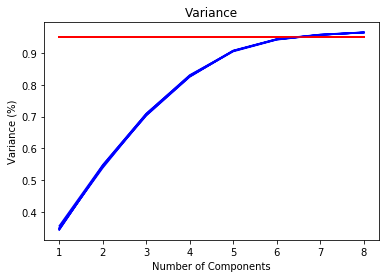

In [408]:
pca, PCA_Embeddings = plot_PCA('o',[data_initial, data_anneal], numPCAcomp)

In [418]:
'''
Plotting out the variance across 30x300 map

At this point, the remaining numPCAcomp are supposed to be the best N features to describe the data.
This is plotted in the next cell to show any similar components across the embeddings
'''
def plot_Var(PCA_Embeddings, numPCAcomp=25):
    Embedding_Variance = [np.var(PCA_Embeddings[:,:,i]) for i in range(numPCAcomp)]
    plt.plot(Embedding_Variance, color='b')    
    plt.xlabel('Component')
    plt.ylabel('Variance (%)') #for each component
    plt.title("Variance of each component across 30x300 map")
    plt.show()

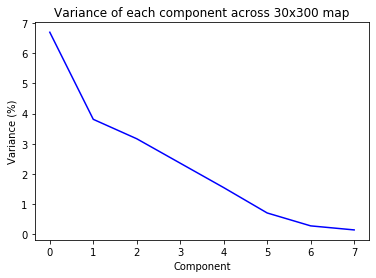

In [419]:
plot_Var(PCA_Embeddings, numPCAcomp)

In [414]:
'''
Plotting out the similarity for each embedding
'''

#import matplotlib as m
#cdict = {
#  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
#  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
#}
#cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def plot_embeddings(PCA_Embeddings,numPCAcomp=25):
    fig= plt.figure(figsize=(20,20))
    ax=[]

    for i in range(numPCAcomp):
        ax.append(fig.add_subplot(5,5,i+1))
        # plotting pseudocolor with global min/max scale
        pcolor=ax[-1].pcolor(PCA_Embeddings[:,:,i])
                             #vmin=np.amin(PCA_Embeddings), 
                             #vmax=np.amax(PCA_Embeddings),
                             #cmap=cm
        ax[i].set_title('Component = '+str(i))
        #ax[-1].axis('scaled')
        ax[-1].invert_yaxis()
        #pcolor.set_clim(0, 2)
        fig.colorbar(pcolor)

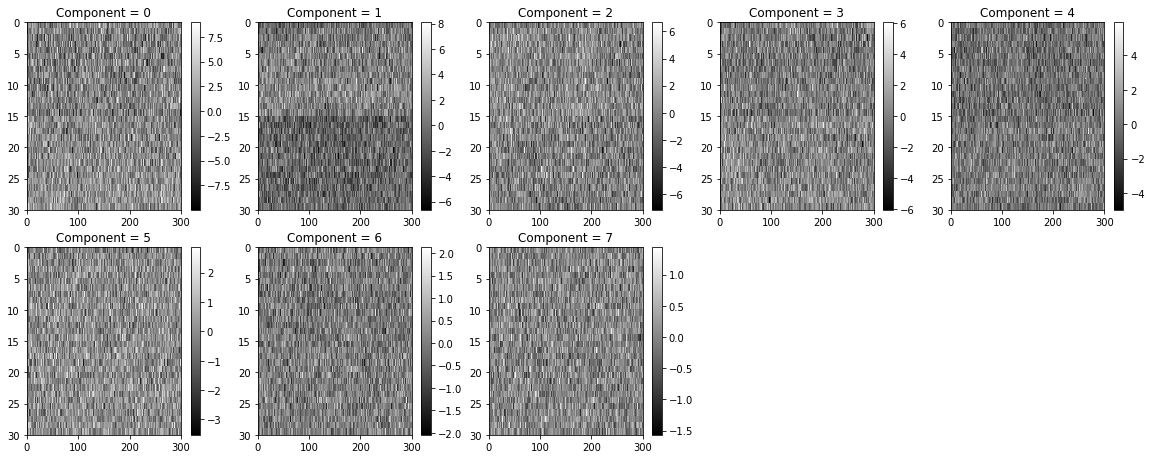

In [415]:
plot_embeddings(PCA_Embeddings,numPCAcomp)

In [402]:
def plot_eigenvalues(pca,trainingforML):
    fig= plt.figure(figsize=(3,3))
    ax=fig.subplots(1,1)
    ax.plot(pca.mean_,color=[0,0,0,1])
    ax.set_title('Average')
    fig.tight_layout()

    eigenvectors=pca.components_
    fig= plt.figure(figsize=(12,12))
    ax=[]

    X=copy.deepcopy(trainingforML.reshape(-1,trainingforML.shape[2]))
    n_samples = X.shape[0]
    # We center the data and compute the sample covariance matrix.
    X -= np.mean(X, axis=0)
    cov_matrix = np.dot(X.T, X) / n_samples

    for i,eigenvector in enumerate(eigenvectors):
        ax.append(fig.add_subplot(5,5,i+1))
        for j,c in enumerate(eigenvectors):
            ax[i].plot(c,color=[0.5,0.5,0.5,0.5])
        ax[i].plot(eigenvector,color=[1,0,0,1])
        Eigenvalue=np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
        ax[i].set_title('Eigenvalue = '+str(round(Eigenvalue,3)))
    fig.tight_layout()

ValueError: shapes (162,162) and (41,) not aligned: 162 (dim 1) != 41 (dim 0)

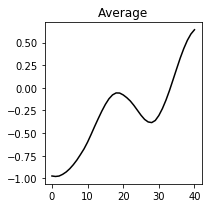

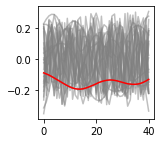

In [404]:
#TODO: fix the trainingforML dimension

trainingforML = data[0].Fe_range

plot_eigenvalues(pca,trainingforML)

## Conclusion

At this point, PCA seems to yield no significant result. It fails to extract information for several reasons + backed by several evidence.


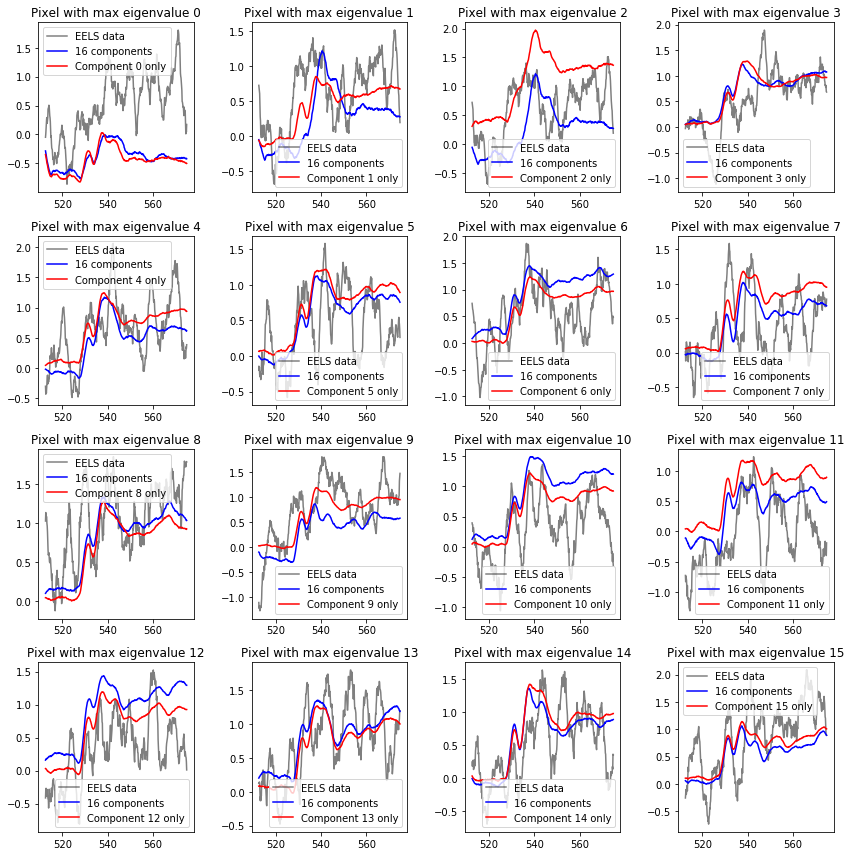

In [161]:
eigenvectors=PCA.components_
fig= plt.figure(figsize=(12,12))
ax=[]
#fig.suptitle('Datapoints with highest score for each component')


# iterate through each eigenvalue
for i,eigenvector in enumerate(eigenvectors):
    ax.append(fig.add_subplot(4,4,i+1))
    
    indexes=np.unravel_index(np.argmax(PCAembeddings[:,:,i], axis=None), PCAembeddings[:,:,i].shape)
    # Explanation of unravel_index: https://stackoverflow.com/a/48138599/8742400 
    # ax[i].text(550,3,indexes)
    ax[i].plot(corrected_xaxis[1000:1500],trainingforML[indexes][1000:1500],color=[0,0,0,0.5],label='EELS data')
    
    # Plotting prediction based on all components (in blue)
    predicted=np.dot(PCAembeddings[indexes], eigenvectors)+PCA.mean_
    ax[i].plot(corrected_xaxis[1000:1500],predicted[1000:1500],color=[0,0,1,1],label=str(numPCAcomp)+' components')
    
    # Plotting prediction based on single component (in red)
    weight=PCAembeddings[indexes][i]
    predicted_with_single_comp = eigenvector*weight+PCA.mean_
    ax[i].plot(corrected_xaxis[1000:1500],predicted_with_single_comp[1000:1500],color=[1,0,0,1],label='Component '+str(i)+' only')
    
    ax[i].set_title('Pixel with max eigenvalue '+str(i))
    ax[i].legend()
fig.tight_layout()